In [ ]:
!pip install stanfordnlp
!pip install stanza
!pip install vaderSentiment

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer 
import stanfordnlp
import xml.etree.ElementTree as ET
import io
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from tqdm.notebook import tqdm
from nltk.stem import PorterStemmer

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [ ]:
def iterate_sentence(sentences):
    sentence_attributes = sentences.attrib
    print(sentence_attributes)
    
xml_data = 'Restaurants.xml'
etree = ET.parse(xml_data)
data = []
distinct_categories = set()
# Categories split
for sentence in etree.iter('sentence'):
  aspect_cats = [ac.attrib for ac in sentence.find('aspectCategories')]
  for cat in aspect_cats:
    distinct_categories.add(cat['category'])

for sentence in etree.iter('sentence'):
    sentence_id = sentence.attrib.get('id')
    text = sentence.find('text').text # [0].text
    aspect_terms = [at.attrib for at in sentence.find('aspectTerms')] if sentence.find('aspectTerms') else []
    aspect_cats = [ac.attrib for ac in sentence.find('aspectCategories')]
    all_cats = {i: True for i in distinct_categories}
    for cat in aspect_cats:
        all_cats[cat['category']] = False if cat['polarity'] == 'negative' else True
    curr_data = {
        'sentence_id': sentence_id,
        'text': text,
        'aspect_terms': aspect_terms,
        'aspect_cats': aspect_cats
    }
    curr_data.update(all_cats)
    data.append(curr_data)
print(len(data))
# print(ET.parse(xml_data).getroot())
# iterate_sentence(ET.parse(xml_data).getroot())

In [ ]:
df_full = pd.DataFrame(data)
df = df_full.drop(['aspect_terms', 'aspect_cats'], axis=1)
df.head(10)

In [ ]:
df_cats = df.drop(['sentence_id', 'text'], axis=1)
counts = []
categories = list(df_cats.columns.values)
for i in categories:
    counts.append((i, df_cats[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

Text(0.5, 0, 'category')

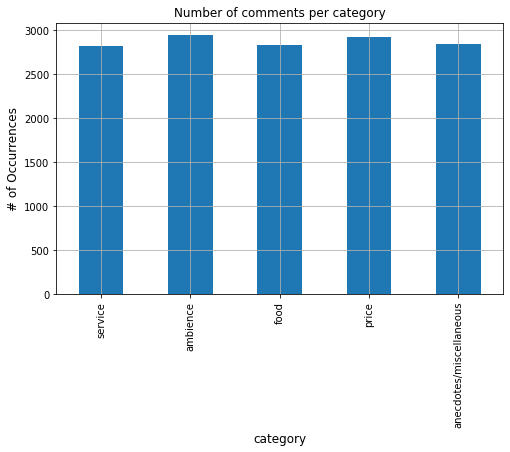

In [ ]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, '# of categories')

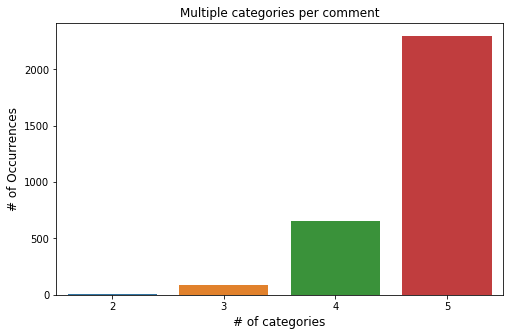

In [ ]:
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [ ]:
print('Percentage of comments that are not labelled:')
print(len(df[(df['anecdotes/miscellaneous']==0) & (df['food']==0) & (df['service']==0) & (df['price']== 0) & (df['ambience']==0)]) / len(df))

In [ ]:
lens = df.text.str.len()
lens.hist(bins = np.arange(0,2000,100))

In [ ]:
print('Number of missing text:')
df['text'].isnull().sum()

In [ ]:
def convert_lower_case(data):
    return np.char.lower(data)

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text

def preprocess(data):
    data = convert_lower_case(data)
    data = remove_apostrophe(data)
#     data = convert_numbers(data)
    data = stemming(data) # needed again as we need to stem the words
    data = remove_punctuation(data) # needed again as num2word is giving few hypens and commas fourty-one
    data = remove_stop_words(data) # needed again as num2word is giving stop words 101 - one hundred and one
    return data

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [ ]:
df['text'] = df['text'].map(lambda com : clean_text(com))
# df['original_text'] = df['test']
# df['text'] = df['text'].map(lambda com : preprocess(com))

In [ ]:
categories = ['anecdotes/miscellaneous', 'food', 'service', 'price', 'ambience']
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)
X_train, X_test = train.text, test.text
print(X_train.shape)
print(X_test.shape)

(2037,)
(1004,)


In [ ]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print(f'Processing scores for {category}\n')
    NB_pipeline.fit(X_train, train[category])
    prediction = NB_pipeline.predict(X_test)
    print(f' Accuracy is {accuracy_score(test[category], prediction)*100}\n Precision is {precision_score(test[category], prediction)*100}\n Recall is {recall_score(test[category], prediction)*100}\n F1_score is {f1_score(test[category], prediction)*100}\n')
    print('--------------------------------------------')
    print('\n')

Processing scores for anecdotes/miscellaneous

 Accuracy is 93.62549800796812
 Precision is 93.62549800796812
 Recall is 100.0
 F1_score is 96.70781893004114

--------------------------------------------


Processing scores for food

 Accuracy is 92.52988047808765
 Precision is 92.52988047808765
 Recall is 100.0
 F1_score is 96.12002069322297

--------------------------------------------


Processing scores for service

 Accuracy is 92.13147410358566
 Precision is 92.13147410358566
 Recall is 100.0
 F1_score is 95.90461378952826

--------------------------------------------


Processing scores for price

 Accuracy is 96.21513944223108
 Precision is 96.21513944223108
 Recall is 100.0
 F1_score is 98.07106598984771

--------------------------------------------


Processing scores for ambience

 Accuracy is 96.71314741035857
 Precision is 96.71314741035857
 Recall is 100.0
 F1_score is 98.32911392405063

--------------------------------------------




In [ ]:
stanfordnlp.download('en')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import stanza
stanza.download('en') # download English model
nlp = stanza.Pipeline('en') 

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

In [ ]:
def vander_sentiment(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(str(sentence))
    if sentiment_dict['compound'] >= 0.05 :
        return "Positive"
    elif sentiment_dict['compound'] <= - 0.05 :
        return "Negative"
    else :
        return "Neutral"

def blob_sentiment(sentence):
    return TextBlob(str(sentence)).sentiment.polarity

# Aspect Based Sentiment Analysis
def get_aspect_terms(txt):
    try:
        txt = txt.lower() # LowerCasing the given Text
        sentList = nltk.sent_tokenize(txt) # Splitting the text into sentences
        stop_words = set(stopwords.words('english'))
        fcluster = []
        totalfeatureList = []
        finalcluster = []
        dic = {}
        for line in sentList:
            newtaggedList = []
            txt_list = nltk.word_tokenize(line) # Splitting up into words
            taggedList = nltk.pos_tag(txt_list) # Doing Part-of-Speech Tagging to each word
            newwordList = []
            flag = 0
            for i in range(0,len(taggedList)-1):
                if(taggedList[i][1]=="NN" and taggedList[i+1][1]=="NN"): # If two consecutive words are Nouns then they are joined together
                    newwordList.append(taggedList[i][0]+taggedList[i+1][0])
                    flag=1
                else:
                    if(flag==1):
                        flag=0
                        continue
                    newwordList.append(taggedList[i][0])
                    if(i==len(taggedList)-2):
                        newwordList.append(taggedList[i+1][0])

            finaltxt = ' '.join(word for word in newwordList) 
            new_txt_list = nltk.word_tokenize(finaltxt)
            wordsList = [w for w in new_txt_list if not w in stop_words]
            taggedList = nltk.pos_tag(wordsList)
            doc = nlp(finaltxt)
            dep_node = []
            for dep_edge in doc.sentences[0].dependencies:
              dep_node.append([dep_edge[2].text, dep_edge[0].id, dep_edge[1]])
            for i in range(0, len(dep_node)):
              if (int(dep_node[i][1]) != 0):
                dep_node[i][1] = newwordList[(int(dep_node[i][1]) - 1)]

            featureList = []
            categories = []
            for i in taggedList:
                if(i[1]=='NN' or i[1]=='NNS'):
                    featureList.append(list(i)) # For features for each sentence
                    totalfeatureList.append(list(i)) # Stores the features of all the sentences in the text
                    categories.append(i[0])
            for i in featureList:
                filist = []
                for j in dep_node:
                    if i[0] in j:
                      filist.append(j[1])
                      if j[2] in ["neg"]:
                        sentiment = "Negative"
                      else:
                        sentiment = "Neutral"
                    filist = [str(k) for k in filist if k != i[0]]
                fcluster.append([i[0], filist, sentiment])
        for i in totalfeatureList:
            dic[i[0]] = i[1]

        for i in fcluster:
            if(dic[i[0]]=="NN"):
                temp = " ".join(i[1])
                i.append([vander_sentiment(temp), blob_sentiment(temp)])
                finalcluster.append(i)
        
        return finalcluster
    except Exception as e:
        print(sentiment)
        print(e)
        return []

In [ ]:
get_aspect_terms("The food is good, but the staff was so horrible to us")

[['food', ['good'], 'Neutral', ['Positive', 0.7]],
 ['staff', ['horrible'], 'Neutral', ['Negative', -1.0]]]

In [ ]:
df_test = df_full

In [ ]:
df_test.shape

(3041, 9)

In [ ]:
all_texts = df_test['text'].tolist()
aspect_results = []
with tqdm(total=len(all_texts)) as bar:
  for txt in all_texts:
      bar.update(1)
      aspect_results.append(get_aspect_terms(txt))

In [ ]:
df_test.head()

In [ ]:
original_aspects = df_test['aspect_terms'].tolist()

altered_original_aspects = []
pos_predicted_aspects = []
vander_predicted_aspects = []
blob_predicted_aspects = []

for asp in original_aspects:
  if asp:
    altered_original_aspects.append({i['term']: i['polarity'] for i in asp})
  else:
    altered_original_aspects.append({})

for asp_res in aspect_results:
  if asp_res:
    pos_predicted_aspects.append({
        i[0]: i[2] for i in asp_res
    })

    vander_predicted_aspects.append({
        i[0]: str(i[3][0]).lower() for i in asp_res
    })

    blob_predicted_aspects.append({
        i[0]: 'positive' if i[3][1] > 0.35 else 'negative' if i[3][1] < -0.35 else 'neutral' for i in asp_res
    })
  else:
    pos_predicted_aspects.append({})
    vander_predicted_aspects.append({})
    blob_predicted_aspects.append({})

In [ ]:
def get_sentiment_specific_aspects(all_aspects):
  positive_aspects = []
  negative_aspects = []
  neutral_aspects = []

  for i in all_aspects:
    for k, v in i.items():
      all_pos = []
      all_negs = []
      all_neuts = []
      if v == 'positive':
        all_pos.append((k, v))
      elif v == 'negative':
        all_negs.append((k, v))
      else:
        all_neuts.append((k, v))
    positive_aspects.append(all_pos)
    negative_aspects.append(all_negs)
    neutral_aspects.append(all_neuts)
  return positive_aspects, negative_aspects, neutral_aspects

In [ ]:
original_positive_aspects, original_negative_aspects, original_neutral_aspects = get_sentiment_specific_aspects(altered_original_aspects)
pos_positive_aspects, pos_negative_aspects, pos_neutral_aspects = get_sentiment_specific_aspects(pos_predicted_aspects)
vander_positive_aspects, vander_negative_aspects, vander_neutral_aspects = get_sentiment_specific_aspects(vander_predicted_aspects)
blob_positive_aspects, blob_negative_aspects, blob_neutral_aspects = get_sentiment_specific_aspects(blob_predicted_aspects)

In [ ]:
pos_accuracy = {}
vander_accuracy = {}
blob_accuracy = {}

total_positives = 0
total_negatives = 0
total_neutrals = 0

pos_positive_count = 0
vander_positive_count = 0
blob_positive_count = 0

for idx, asp in enumerate(original_positive_aspects):
  total_positives += len(asp)
  # pos_positive_count += len(set(pos_positive_aspects[idx]) & set(asp))
  vander_positive_count += len(set(vander_positive_aspects[idx]) & set(asp))
  blob_positive_count += len(set(blob_positive_aspects[idx]) & set(asp))

vander_accuracy['positive'] = vander_positive_count / total_positives
blob_accuracy['positive'] = blob_positive_count / total_positives

print(f"Total positive: {total_positives}, Vander positive: {vander_positive_count}, Blob positive: {blob_positive_count}")

pos_negative_count = 0
vander_negative_count = 0
blob_negative_count = 0
for idx, asp in enumerate(original_negative_aspects):
  total_negatives += len(asp)
  pos_negative_count += len(set(pos_negative_aspects[idx]) & set(asp))
  vander_negative_count += len(set(vander_negative_aspects[idx]) & set(asp))
  blob_negative_count += len(set(blob_negative_aspects[idx]) & set(asp))

vander_accuracy['negative'] = vander_negative_count / total_negatives
blob_accuracy['negative'] = blob_negative_count / total_negatives
pos_accuracy['negative'] = pos_negative_count / total_negatives

print(f"Total negative: {total_negatives}, Vander negative: {vander_negative_count}, Blob negative: {blob_negative_count}")

pos_neutral_count = 0
vander_neutral_count = 0
blob_neutral_count = 0
for idx, asp in enumerate(original_neutral_aspects):
  total_neutrals += len(asp)
  pos_neutral_count += len(set(pos_neutral_aspects[idx]) & set(asp))
  vander_neutral_count += len(set(vander_neutral_aspects[idx]) & set(asp))
  blob_neutral_count += len(set(blob_neutral_aspects[idx]) & set(asp))

vander_accuracy['neutral'] = vander_neutral_count / total_neutrals
blob_accuracy['neutral'] = blob_neutral_count / total_neutrals
pos_accuracy['neutral'] = pos_neutral_count / total_negatives

print(f"Total neutral: {total_neutrals}, Vander neutral: {vander_neutral_count}, Blob neutral: {blob_neutral_count}")

print(f"Accuracy: \n Vander: {vander_accuracy},\n  Blob: {blob_accuracy},\n  POS: {pos_accuracy}")

Total positive: 8, Vander positive: 1, Blob positive: 1
Total negative: 3, Vander negative: 1, Blob negative: 1
Total neutral: 19, Vander neutral: 2, Blob neutral: 2
Accuracy: 
 Vander: {'positive': 0.125, 'negative': 0.3333333333333333, 'neutral': 0.10526315789473684},
  Blob: {'positive': 0.125, 'negative': 0.3333333333333333, 'neutral': 0.10526315789473684},
  POS: {'negative': 0.0, 'neutral': 0.0}
